In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from collections import defaultdict
import copy
import importlib

# Add the utils directory to the Python path and import utils
from utils import *
import MLPQLearningAgent
importlib.reload(MLPQLearningAgent)
from MLPQLearningAgent import *
from OracleQLearningAgent import *
from TransitionModelLearner import *

# Ensure we reload the updated MLPQLearningAgentNotUseCondition module
import MLPQLearningAgentNotUseCondition
importlib.reload(MLPQLearningAgentNotUseCondition)
from MLPQLearningAgentNotUseCondition import *


In [2]:
EPISODES = 600

grid_world = GridWorld(
    n_rows=N_ROWS,
    n_cols=N_COLS,
    start=START,
    goal=GOAL,
    walls = WALLS,
    step_reward= -0.1,
    goal_reward=1,
    bump_reward=-0.2,
    gamma=0.95
)

def oracle_model(s, action):
    """Oracle model that predicts the next state for all 8 actions (including diagonal actions 4-7)"""
    s_model_next, r_model, done_model = grid_world.step(grid_world.from_index(s), action, ACTIONS_8)
    return s_model_next, r_model, done_model

In [3]:
  # 1. Q-learning with 4 actions
agent_plain_4_action = QLearningAgent(grid_world, 4, seed=42)
agent_plain_4_action.train(ACTIONS_4, epsilon_greedy)
results_plain = agent_plain_4_action.get_results(moving_average)

# ----------------------------------------
# policy4 = Visualizer.derive_policy(agent_plain_4_action.Q, N_ROWS, N_COLS)
# Visualizer.render_policy(policy4, N_ROWS, N_COLS, WALLS, START, GOAL)
#Visualizer.print_value_grid(agent_plain_4_action.Q, N_ROWS, N_COLS)

# 3. Oracle Q-learning with 5 actions 
# 5.Q-learning (non-conditional) orange curve
oracle_agent = OracleQLearningAgent(grid_world = grid_world, n_actions = len(ACTIONS_5),
                                        episodes = EPISODES, base_q_table=copy.deepcopy(agent_plain_4_action.Q),
                                        use_conditional=True,
                                        use_model=True,
                                        seed=23)

oracle_agent.train_with_oracle(ACTIONS_5, epsilon_greedy, oracle_model)
policy5 = Visualizer.derive_policy(oracle_agent.Q, N_ROWS, N_COLS)
Visualizer.render_policy(policy5, N_ROWS, N_COLS, WALLS, START, GOAL)
# # # ----------------------------------------

Training (4 actions) complete!

Policy Visualization:
 S  ↘  →  ↘  ↘  →  →  →  ←  →  →  ↓  ←  ↓  ↘  ↑  ↑  →  ↑  ←  ↑  →  ↑  ←  ↓ 
 ↘  ↘  →  ↘  ↘  ↘  ↘  ↘  ↓  ↘  ↘  →  →  ←  →  ←  →  ←  ↑  →  ↑  →  →  ↓  ↓ 
 ↓  →  ↘  ↘  →  →  ↘  ↘  ↘  →  →  →  ↘  →  ↓  ↓  →  ↘  →  ↓  ↓  ↓  ↓  ↓  ← 
 ↓  ↓  →  →  →  ↘  →  ↘  ↓  ↘  ↘  →  →  ↑  →  ↓  ↘  ↘  →  →  ↓  →  →  ↓  ↓ 
 ↓  ↓  ↘  ↓  →  ↘  →  →  ↘  ↓  ↘  ↘  ↓  ↘  ↘  →  ↘  ↘  ↓  ↘  →  ↘  ↓  ↓  ↓ 
 ↓  ↓  →  ↓  ←  ↘  ↑  →  →  ↘  →  ↘  ↘  →  →  ↘  ↘  →  →  →  →  →  ↘  ↓  ↓ 
 ↓  ↓  ↑  ←  ↘  ↓  →  →  ↑  →  ↘  ↘  ↘  ↓  →  →  →  ↓  →  →  ↑  ↑  ▓  ↘  ↓ 
 ↓  ↘  ↘  ↘  ↘  ↓  ↘  ↘  →  ↘  →  →  ↘  ↓  ↘  ↓  →  ↓  →  ↑  ↑  ↑  ▓  ↘  ↓ 
 ↓  ↓  →  ↓  →  ↓  ↑  ↓  →  →  ↘  →  →  ↘  ↓  ↓  ↘  ↘  ↘  ↘  ↘  ↓  ▓  ↘  ↓ 
 →  →  ↓  ↘  ↓  →  ↓  →  ↘  ↘  ↘  →  →  ↘  ↘  ↘  →  →  ↘  ↓  ↘  ↓  ▓  ↘  ↓ 
 ↓  ↓  ↘  ↓  ↑  →  ↑  ↑  ↘  ↘  ↘  ↘  ↘  ↘  →  ↘  ↘  ↘  ↘  →  ↘  ↓  ▓  ↓  ↓ 
 ←  ↓  →  ↓  ←  ←  ←  ←  ↓  ↘  →  ↘  ↓  ↘  →  →  ↘  ↘  →  →  →  ↘  ▓  ↓  ↓ 
 →  ↘  ←  →  ↘  ↓  ↘  ↘  ↓  →  →  

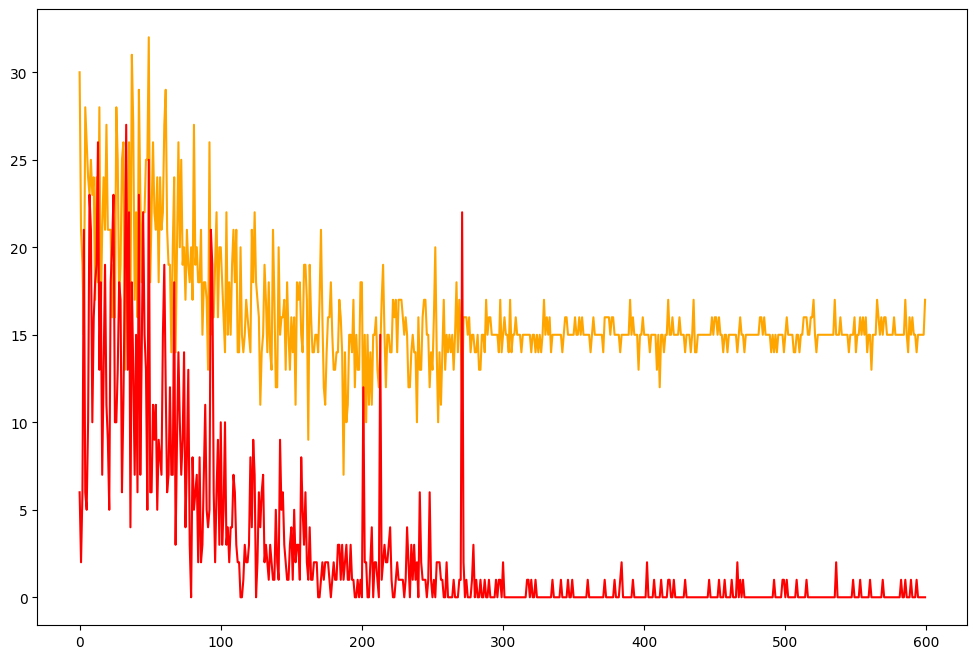

In [4]:
plt.figure(figsize=(12, 8))
plt.plot(oracle_agent.reuse_count, label='Oracle Q-learning (5 actions, reuse the condition)', color='orange')
plt.plot(oracle_agent.reject_count, label='Oracle Q-learning (5 actions, reject the condition)', color='red')

Running multiple experiments for statistical analysis...
Running experiment 1/5...
Training (4 actions) complete!
Training (8 actions) complete!
Running experiment 2/5...
Training (4 actions) complete!
Training (8 actions) complete!
Running experiment 3/5...
Training (4 actions) complete!
Training (8 actions) complete!
Running experiment 4/5...
Training (4 actions) complete!
Training (8 actions) complete!
Running experiment 5/5...
Training (4 actions) complete!
Training (8 actions) complete!
MLP reuse counts per run: [array([ 0., 27., 54.,  5., 60., 31., 92., 57., 12., 40., 52., 12.,  5.,
        4.,  2., 25., 21., 29., 15., 34., 52., 21., 15., 12., 21., 12.,
       10., 19., 12., 18.,  8., 20., 20., 13., 15., 15., 13., 20., 30.,
       11., 34., 22., 23., 34., 10., 14., 27., 24., 45., 24., 26., 27.,
       31., 27., 18., 19., 25., 18., 13., 15., 18., 13., 16., 17., 20.,
       20., 21., 26., 13., 21., 18., 20., 34., 15., 22., 26.,  9., 26.,
       26., 24., 19., 23., 12., 29., 30., 21

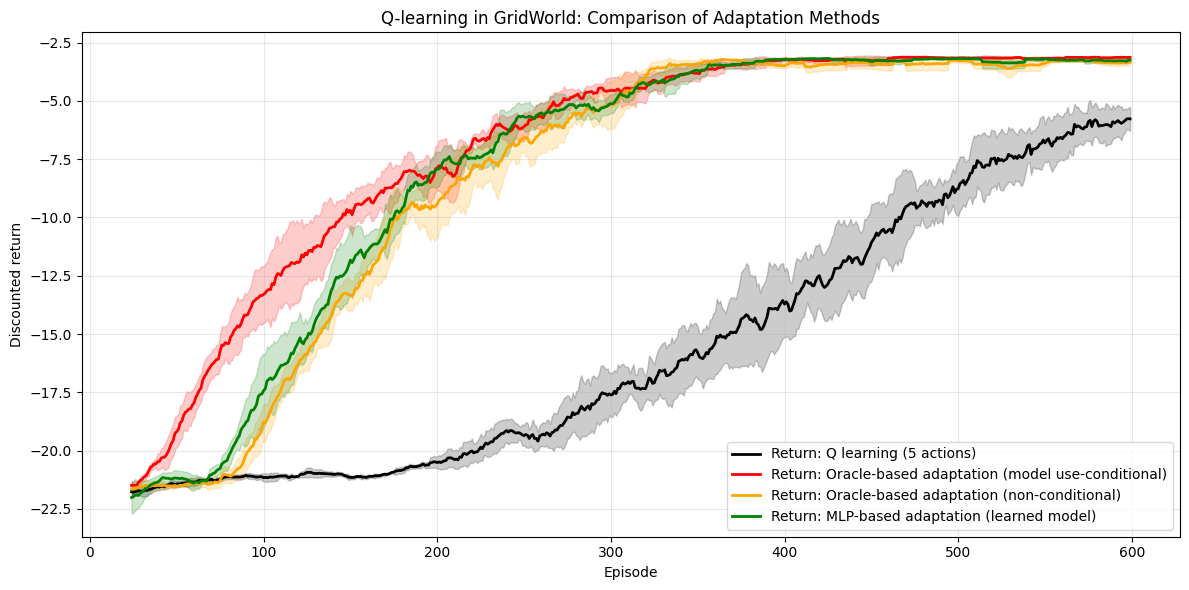

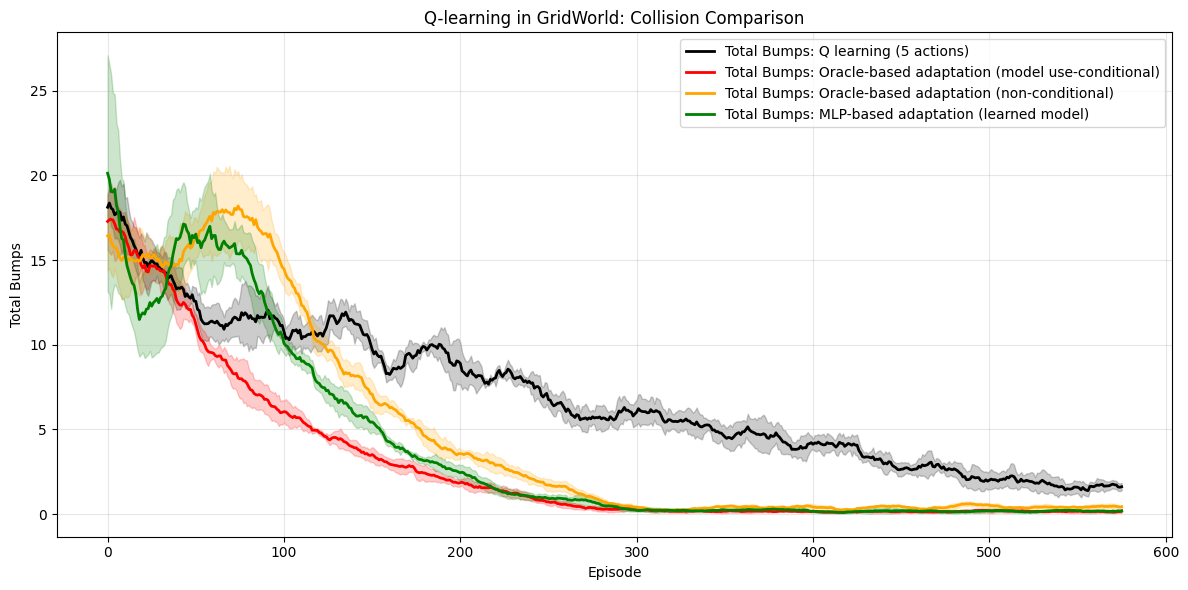

In [5]:
TEST_ACTION = ACTIONS_8
def run_multiple_experiments(n_runs=5, base_seed=123):
    """Run multiple experiments with different seeds and return statistics"""
    
    # Storage for all runs
    all_returns4 = []
    all_returns5plain = []
    all_returns5oracle = []
    all_returns5mlp = []
    all_returns5mlp_no_cond = []
    all_bumps4 = []
    all_bumps5plain = []
    all_bumps5oracle = []
    all_bumps5mlp = []
    all_bumps5mlp_no_cond = []
    all_bumps5ignore = []
    all_reuse_counts_mlp = []
    all_reuse_counts_oracle = []
    
    for run in range(n_runs):
        current_seed = base_seed + run * 42
        # Reset random seeds
        rng = np.random.default_rng(current_seed)
        random.seed(current_seed)
        np.random.seed(current_seed)
        torch.manual_seed(current_seed)
        
        print(f"Running experiment {run + 1}/{n_runs}...")
        
        # 1. Q-learning with 4 actions
        agent_plain_4_action = QLearningAgent(grid_world = grid_world, n_actions= len(ACTIONS_4), episodes = EPISODES, seed=current_seed)
        agent_plain_4_action.train(ACTIONS_4, epsilon_greedy)
        results_plain = agent_plain_4_action.get_results(moving_average)
        all_returns4.append(results_plain['returns'])
        all_bumps4.append(results_plain['bumps'])
        
        # 4. MLP Q-learning with learned model (conditional)
        mlp_agent = MLPQLearningAgentNotUseCondition(grid_world = grid_world,
                                      n_actions = len(TEST_ACTION),
                                      episodes = EPISODES,
                                      use_model=True, 
                                      use_conditional=True,
                                      base_q_table=copy.deepcopy(agent_plain_4_action.Q), seed=current_seed)
        mlp_agent.train_with_learned_model(TEST_ACTION, epsilon_greedy)
        mlp_results = mlp_agent.get_results(moving_average)
        all_returns5mlp.append(mlp_results['returns'])
        all_bumps5mlp.append(mlp_results['bumps'])
        all_reuse_counts_mlp.append(mlp_agent.reuse_count)
        # 5.Q-learning (non-conditional) orange curve
        mlp_agent_no_cond = OracleQLearningAgent(grid_world = grid_world, 
                                                n_actions = len(TEST_ACTION),
                                                episodes = EPISODES,
                                                base_q_table=copy.deepcopy(agent_plain_4_action.Q),
                                                use_conditional=False,
                                                use_model=True,
                                                seed=current_seed)
        
        mlp_agent_no_cond.train_with_oracle(TEST_ACTION, epsilon_greedy, oracle_model)
        mlp_results_no_cond = mlp_agent_no_cond.get_results(moving_average)
        all_returns5mlp_no_cond.append(mlp_results_no_cond['returns'])
        all_bumps5mlp_no_cond.append(mlp_results_no_cond['bumps'])
        # red curve
        oracle_agent_run = OracleQLearningAgent(grid_world = grid_world,
                                                n_actions = len(TEST_ACTION),
                                                episodes = EPISODES,
                                                base_q_table=copy.deepcopy(agent_plain_4_action.Q),
                                                use_conditional=True,
                                                use_model=True,
                                                seed=current_seed)
        
        oracle_agent_run.train_with_oracle(TEST_ACTION, epsilon_greedy, oracle_model)
        oracle_results_run = oracle_agent_run.get_results(moving_average)
        all_returns5oracle.append(oracle_results_run['returns'])
        all_bumps5oracle.append(oracle_results_run['bumps'])
        all_reuse_counts_oracle.append(oracle_agent_run.reuse_count)
        # black curve
        agent_plain = QLearningAgent(grid_world = grid_world,
                                     n_actions = len(TEST_ACTION),
                                     episodes = EPISODES, seed=current_seed)
        agent_plain.train(TEST_ACTION, epsilon_greedy)
        results_plain = agent_plain.get_results(moving_average)
        all_returns5plain.append(results_plain['returns'])
        all_bumps5plain.append(results_plain['bumps'])
        
    # Calculate statistics
    all_returns4 = np.array(all_returns4)
    all_returns5plain = np.array(all_returns5plain)
    all_returns5oracle = np.array(all_returns5oracle)
    all_returns5mlp = np.array(all_returns5mlp)
    all_returns5mlp_no_cond = np.array(all_returns5mlp_no_cond)
    all_bumps4 = np.array(all_bumps4)
    all_bumps5plain = np.array(all_bumps5plain)
    all_bumps5oracle = np.array(all_bumps5oracle)
    all_bumps5mlp = np.array(all_bumps5mlp)
    all_bumps5mlp_no_cond = np.array(all_bumps5mlp_no_cond)
    all_bumps5ignore = np.array(all_bumps5ignore)
    
    # Calculate moving averages for all runs
    ma_w = 25
    all_ret_ma4 = np.array([moving_average(returns, w=ma_w) for returns in all_returns4])
    all_ret_ma5plain = np.array([moving_average(returns, w=ma_w) for returns in all_returns5plain])
    all_ret_ma5oracle = np.array([moving_average(returns, w=ma_w) for returns in all_returns5oracle])
    all_ret_ma5mlp = np.array([moving_average(returns, w=ma_w) for returns in all_returns5mlp])
    all_ret_ma5mlp_no_cond = np.array([moving_average(returns, w=ma_w) for returns in all_returns5mlp_no_cond])
    
    all_bumps4_avg = np.array([moving_average(bumps, w=ma_w) for bumps in all_bumps4])
    all_bumps5plain_avg = np.array([moving_average(bumps, w=ma_w) for bumps in all_bumps5plain])
    all_bumps5oracle_avg = np.array([moving_average(bumps, w=ma_w) for bumps in all_bumps5oracle])
    all_bumps5mlp_avg = np.array([moving_average(bumps, w=ma_w) for bumps in all_bumps5mlp])
    all_bumps5mlp_no_cond_avg = np.array([moving_average(bumps, w=ma_w) for bumps in all_bumps5mlp_no_cond])
    
    return {
        'returns': {
            '4_actions': {'mean': np.mean(all_ret_ma4, axis=0), 'std': np.std(all_ret_ma4, axis=0)},
            '5_plain': {'mean': np.mean(all_ret_ma5plain, axis=0), 'std': np.std(all_ret_ma5plain, axis=0)},
            '5_oracle': {'mean': np.mean(all_ret_ma5oracle, axis=0), 'std': np.std(all_ret_ma5oracle, axis=0)},
            '5_mlp': {'mean': np.mean(all_ret_ma5mlp, axis=0), 'std': np.std(all_ret_ma5mlp, axis=0)},
            '5_mlp_no_cond': {'mean': np.mean(all_ret_ma5mlp_no_cond, axis=0), 'std': np.std(all_ret_ma5mlp_no_cond, axis=0)},
        },
        'bumps': {
            '4_actions': {'mean': np.mean(all_bumps4_avg, axis=0), 'std': np.std(all_bumps4_avg, axis=0)},
            '5_plain': {'mean': np.mean(all_bumps5plain_avg, axis=0), 'std': np.std(all_bumps5plain_avg, axis=0)},
            '5_oracle': {'mean': np.mean(all_bumps5oracle_avg, axis=0), 'std': np.std(all_bumps5oracle_avg, axis=0)},
            '5_mlp': {'mean': np.mean(all_bumps5mlp_avg, axis=0), 'std': np.std(all_bumps5mlp_avg, axis=0)},
            '5_mlp_no_cond': {'mean': np.mean(all_bumps5mlp_no_cond_avg, axis=0), 'std': np.std(all_bumps5mlp_no_cond_avg, axis=0)},
        },
        'info': {
            'mlp_reuse_counts': all_reuse_counts_mlp,
            'oracle_reuse_counts': all_reuse_counts_oracle
        }
    }

# Run multiple experiments
print("Running multiple experiments for statistical analysis...")
stats = run_multiple_experiments(n_runs=5)  # Reduced runs for faster execution

# Show the reuse_count captured from MLP agent per run
print('MLP reuse counts per run:', stats['info']['mlp_reuse_counts'])
print('Oracle reuse counts per run:', stats['info']['oracle_reuse_counts'])

# Plot results with shaded error bars
def plot_with_shaded_errors(stats, figsize=(12, 6)):
    """Plot results with shaded error bars"""
    
    # Returns plot
    plt.figure(figsize=figsize)
    
    # Calculate x-axis for each series (they might have different lengths due to moving average)
    episodes_total = EPISODES
    ma_w = 25
    
    # Plot each method with shaded error bars
    methods = [
        #('4_actions', 'Q learning (4 actions)', 'blue'),
        ('5_plain', 'Q learning (5 actions)', 'black'), 
        ('5_oracle', 'Oracle-based adaptation (model use-conditional)', 'red'),
        ('5_mlp_no_cond', 'Oracle-based adaptation (non-conditional)', 'orange'),
        ('5_mlp', 'MLP-based adaptation (learned model)', 'green'),
    ]
    
    for method_key, label, color in methods:
        mean_vals = stats['returns'][method_key]['mean']
        std_vals = stats['returns'][method_key]['std']
        x_vals = np.arange(episodes_total - len(mean_vals), episodes_total)
        
        # Plot mean line
        plt.plot(x_vals, mean_vals, color=color, label=f'Return: {label}', linewidth=2)
        
        # Plot shaded error region (mean ± std)
        plt.fill_between(x_vals, mean_vals - std_vals, mean_vals + std_vals, 
                        color=color, alpha=0.2)
    
    plt.xlabel('Episode')
    plt.ylabel('Discounted return')
    plt.title('Q-learning in GridWorld: Comparison of Adaptation Methods')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Bumps plot
    plt.figure(figsize=figsize)
    
    for method_key, label, color in methods:
        mean_vals = stats['bumps'][method_key]['mean']
        std_vals = stats['bumps'][method_key]['std']
        x_vals = np.arange(len(mean_vals))
        
        # Plot mean line
        plt.plot(x_vals, mean_vals, color=color, label=f'Total Bumps: {label}', linewidth=2)
        
        # Plot shaded error region (mean ± std)
        plt.fill_between(x_vals, mean_vals - std_vals, mean_vals + std_vals, 
                        color=color, alpha=0.2)
    
    plt.xlabel('Episode')
    plt.ylabel('Total Bumps')
    plt.title('Q-learning in GridWorld: Collision Comparison')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Plot the results with shaded error bars
plot_with_shaded_errors(stats)


Raw MLP reuse counts: 5
Raw Oracle reuse counts: 5


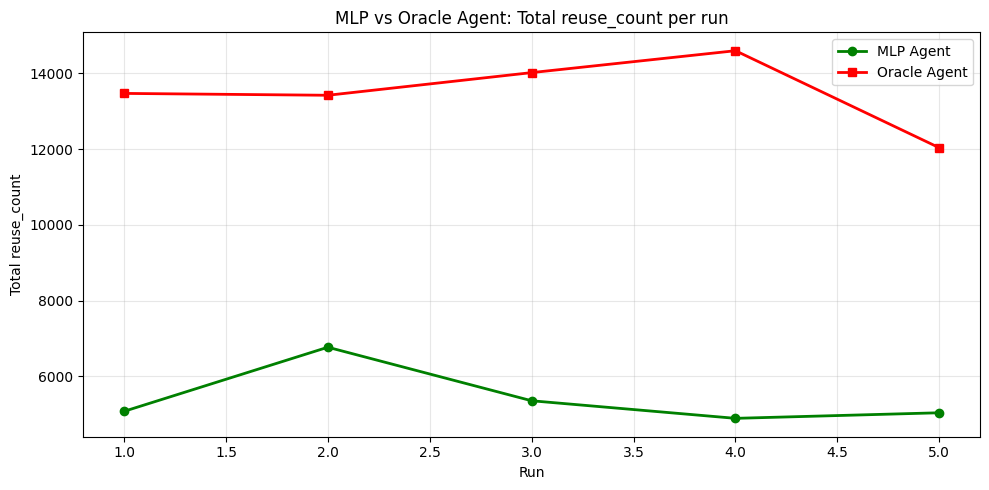

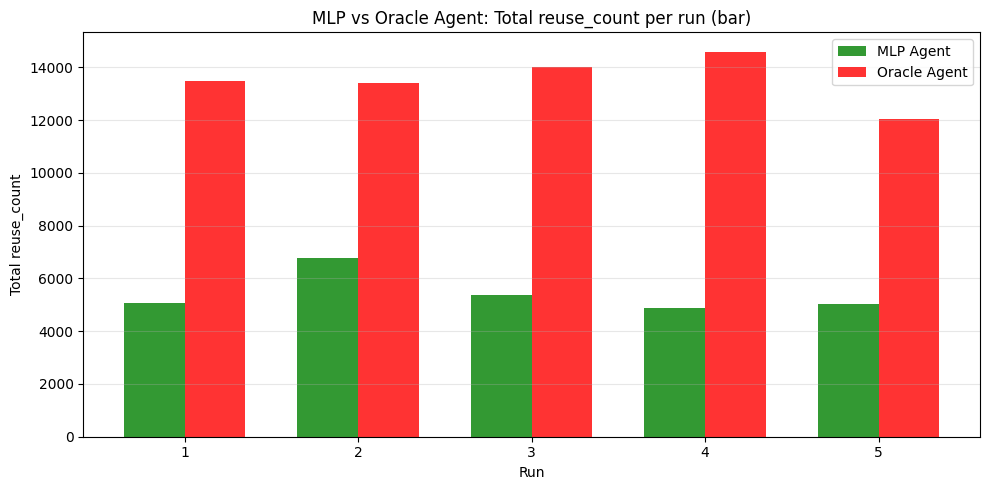

In [6]:
# Plot reuse_count across runs for both MLP and Oracle agents
# Extract the final or total reuse_count value for each run
mlp_counts_raw = stats['info']['mlp_reuse_counts']
oracle_counts_raw = stats['info']['oracle_reuse_counts']
print('Raw MLP reuse counts:', len(mlp_counts_raw))
print('Raw Oracle reuse counts:', len(oracle_counts_raw))
# Check if counts_raw contains arrays or scalars and process accordingly
if isinstance(mlp_counts_raw[0], (list, np.ndarray)):
    mlp_counts = [np.sum(c) if hasattr(c, '__len__') else c for c in mlp_counts_raw]
else:
    mlp_counts = mlp_counts_raw

if isinstance(oracle_counts_raw[0], (list, np.ndarray)):
    oracle_counts = [np.sum(c) if hasattr(c, '__len__') else c for c in oracle_counts_raw]
else:
    oracle_counts = oracle_counts_raw

# Plot comparison line chart
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(mlp_counts) + 1), mlp_counts, marker='o', linewidth=2, color='green', label='MLP Agent')
plt.plot(range(1, len(oracle_counts) + 1), oracle_counts, marker='s', linewidth=2, color='red', label='Oracle Agent')
plt.xlabel('Run')
plt.ylabel('Total reuse_count')
plt.title('MLP vs Oracle Agent: Total reuse_count per run')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plot comparison bar chart
x = np.arange(1, len(mlp_counts) + 1)
width = 0.35
plt.figure(figsize=(10, 5))
plt.bar(x - width/2, mlp_counts, width, color='green', label='MLP Agent', alpha=0.8)
plt.bar(x + width/2, oracle_counts, width, color='red', label='Oracle Agent', alpha=0.8)
plt.xlabel('Run')
plt.ylabel('Total reuse_count')
plt.title('MLP vs Oracle Agent: Total reuse_count per run (bar)')
plt.legend()
plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


In [7]:
# Understanding the structure of reuse_count data
mlp_counts_raw = stats['info']['mlp_reuse_counts']
oracle_counts_raw = stats['info']['oracle_reuse_counts']

print(f"Number of experimental runs: {len(mlp_counts_raw)}")
print(f"Shape of reuse_count per run: {np.array(mlp_counts_raw[0]).shape}")
print(f"\nStructure explanation:")
print(f"- mlp_counts_raw is a list of {len(mlp_counts_raw)} arrays")
print(f"- Each array contains {len(mlp_counts_raw[0])} values (one per episode)")
print(f"- Total data points: {len(mlp_counts_raw)} runs × {len(mlp_counts_raw[0])} episodes = {len(mlp_counts_raw) * len(mlp_counts_raw[0])}")
print(f"\nExample - Run 1, first 10 episodes reuse counts: {mlp_counts_raw[0][:10]}")
print(f"Example - Run 1, total reuse count: {np.sum(mlp_counts_raw[0])}")


Number of experimental runs: 5
Shape of reuse_count per run: (600,)

Structure explanation:
- mlp_counts_raw is a list of 5 arrays
- Each array contains 600 values (one per episode)
- Total data points: 5 runs × 600 episodes = 3000

Example - Run 1, first 10 episodes reuse counts: [ 0. 27. 54.  5. 60. 31. 92. 57. 12. 40.]
Example - Run 1, total reuse count: 5078.0


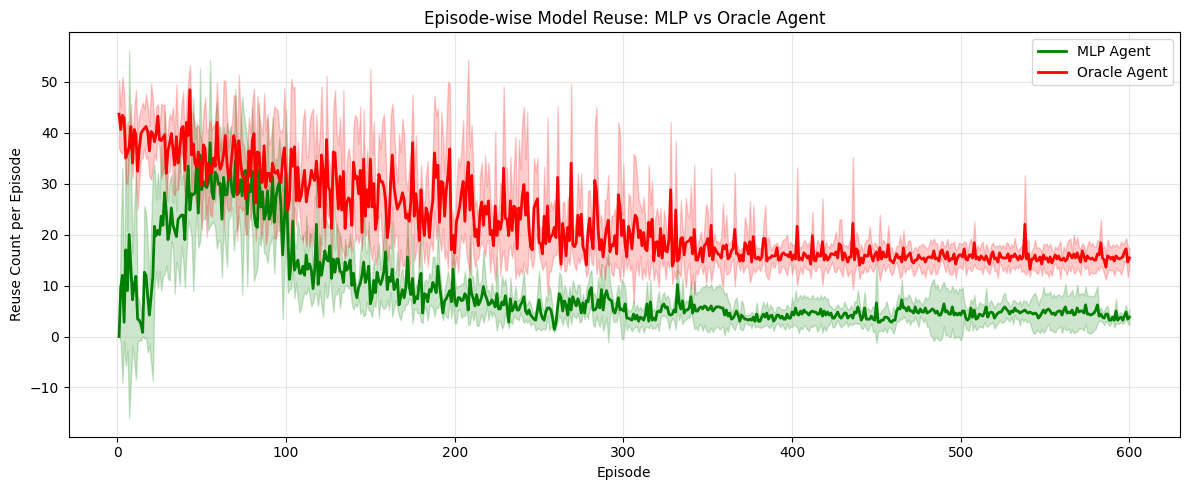


MLP Agent - Average reuse per episode: 9.05
MLP Agent - Total reuse across training: 5427.60

Oracle Agent - Average reuse per episode: 22.51
Oracle Agent - Total reuse across training: 13508.60


In [8]:
# Plot episode-wise reuse counts (showing all 600 episodes)
# This shows how reuse behavior evolves over training

mlp_reuse_array = np.array(stats['info']['mlp_reuse_counts'])  # Shape: (10, 600)
oracle_reuse_array = np.array(stats['info']['oracle_reuse_counts'])  # Shape: (10, 600)

# Calculate mean and std across runs for each episode
mlp_mean_per_episode = np.mean(mlp_reuse_array, axis=0)
mlp_std_per_episode = np.std(mlp_reuse_array, axis=0)
oracle_mean_per_episode = np.mean(oracle_reuse_array, axis=0)
oracle_std_per_episode = np.std(oracle_reuse_array, axis=0)

# Plot episode-wise reuse counts
plt.figure(figsize=(12, 5))
episodes = np.arange(1, EPISODES + 1)

plt.plot(episodes, mlp_mean_per_episode, color='green', label='MLP Agent', linewidth=2)
plt.fill_between(episodes, mlp_mean_per_episode - mlp_std_per_episode, 
                 mlp_mean_per_episode + mlp_std_per_episode, color='green', alpha=0.2)

plt.plot(episodes, oracle_mean_per_episode, color='red', label='Oracle Agent', linewidth=2)
plt.fill_between(episodes, oracle_mean_per_episode - oracle_std_per_episode, 
                 oracle_mean_per_episode + oracle_std_per_episode, color='red', alpha=0.2)

plt.xlabel('Episode')
plt.ylabel('Reuse Count per Episode')
plt.title('Episode-wise Model Reuse: MLP vs Oracle Agent')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\nMLP Agent - Average reuse per episode: {np.mean(mlp_mean_per_episode):.2f}")
print(f"MLP Agent - Total reuse across training: {np.sum(mlp_mean_per_episode):.2f}")
print(f"\nOracle Agent - Average reuse per episode: {np.mean(oracle_mean_per_episode):.2f}")
print(f"Oracle Agent - Total reuse across training: {np.sum(oracle_mean_per_episode):.2f}")
